<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/PSF_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hcipy --upgrade --quiet

In [ ]:
!pip install --force-reinstall jsonschema==3.2.0 --quiet

Run above cells and restart runtime. Continue to run the cells below.

In [1]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet

# **Imports**

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import os
from time import perf_counter
import json
import requests

import mastcasjobs
from hcipy import *

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('dark')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **Single PSF Generator**

Enter FWHM of source in arcsecond : 1.8
Enter AB magnitude of the source  : 0


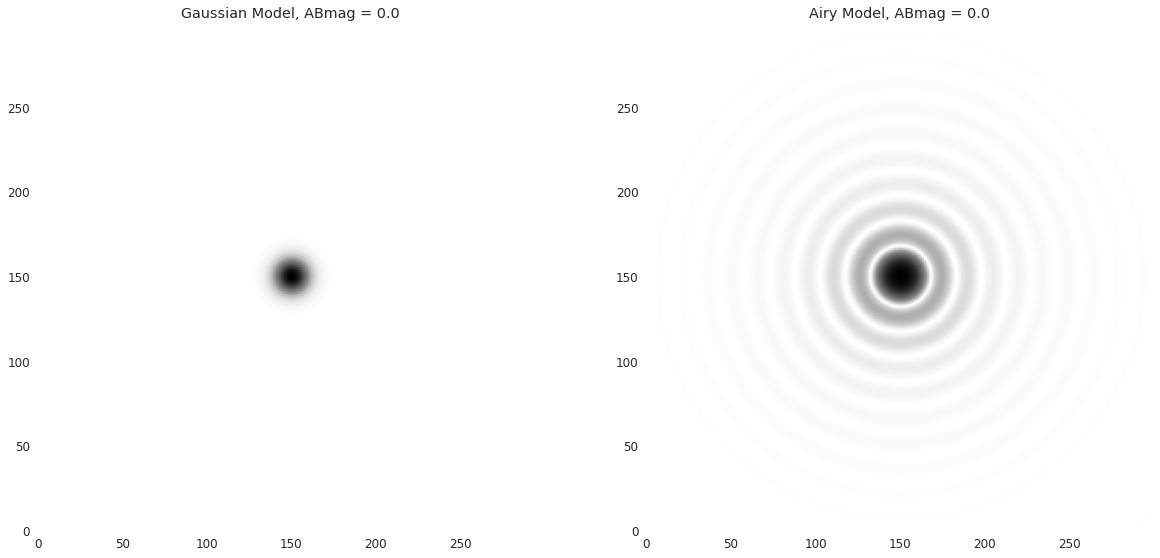

In [20]:
fwhm_in = float(input("Enter FWHM of source in arcsecond : ") or "0.3")
ABmag = float(input("Enter AB magnitude of the source  : ") or "0")

# Flux to AB magnitude
flux = 3631*pow(10,-ABmag/2.5)

pixel_scale = 0.1 #arcsecond

# Input FWHM to detector fwhm conversion
fwhm = fwhm_in/pixel_scale    

# fwhm to sigma conversion
sigma_psf = fwhm*gaussian_fwhm_to_sigma

# Amplitude of a gaussian for given flux and standard deviation.
amplitude_g = flux/(sigma_psf**2*2*np.pi)

amplitude_a = (flux)/(0.8569446798286412*fwhm**2)

# Number of pixels.
n_pix = 300
y, x  = np.mgrid[0:(n_pix), 0:(n_pix)]

# Modelling a 2D gaussian at the center of the image.
model_gauss = models.Gaussian2D(amplitude_g, len(x)//2, len(x)//2, sigma_psf, sigma_psf)

# Modelling a Airy Disk of same amplitude.
model_airy = models.AiryDisk2D(amplitude_a, len(x)//2, len(x)//2, fwhm)

image_g = model_gauss(x,y)

image_a = model_airy(x,y)

# Plot
fix, ax = plt.subplots(1,2,figsize=(20,10))

norm = ImageNormalize(stretch=LogStretch())

ax[0].imshow(np.log10(1+image_g/image_g.max()),origin='lower',cmap='Greys',vmin=1e-11)
ax[0].set_title(f'Gaussian Model, ABmag = {ABmag}')

ax[1].imshow(image_a,origin='lower',cmap='Greys',norm=norm)
ax[1].set_title(f'Airy Model, ABmag = {ABmag}');

In [4]:
image_g.sum(), flux, image_a.sum()

(1.4455271362797477e-07, 1.4455271362797474e-07, 1.4178384747192625e-07)

Airy Disk not modelled properly yet

# **PSF Generator using Source Catalog**


In [6]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 287 (delta 143), reused 230 (delta 110), pack-reused 0
Receiving objects: 100% (287/287), 40.54 MiB | 12.21 MiB/s, done.
Resolving deltas: 100% (143/143), done.


In [7]:
cd INSIST/data

/content/INSIST/data


### **M 67 GALEX NUV**

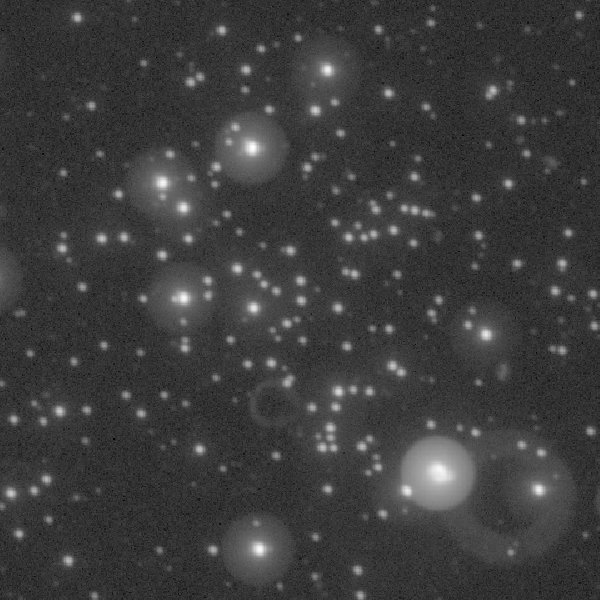

## **GALEX Data**

In [8]:
df = pd.read_csv('M67.csv')
df = df.rename(columns={'ra':'RA','dec':'Dec'}).drop_duplicates(['RA','Dec'])
df 

,casjobsID,objid,tilenum,RA,Dec,e_bv,glon,glat,fov_radius,flux_nuv,fluxerr_nuv,mag_nuv,magerr_nuv,s2n_nuv,flux_fuv,fluxerr_fuv,mag_fuv,magerr_fuv,s2n_fuv,bkgrnd_flux_nuv,bkgrnd_flux_fuv,eff_exptime_nuv,eff_exptime_fuv,artifact_nuv,artifact_fuv,poserr,number_mcat,flux_d3p0_nuv,flux_d4p5_nuv,flux_d7p5_nuv,flux_d12p0_nuv,flux_d18p0_nuv,flux_d25p5_nuv,flux_d34p5_nuv,fluxerr_d3p0_nuv,fluxerr_d4p5_nuv,fluxerr_d7p5_nuv,fluxerr_d12p0_nuv,fluxerr_d18p0_nuv,fluxerr_d25p5_nuv,...,fluxerr_d4p5_fuv,fluxerr_d7p5_fuv,fluxerr_d12p0_fuv,fluxerr_d18p0_fuv,fluxerr_d25p5_fuv,fluxerr_d34p5_fuv,mag_d3p0_fuv,mag_d4p5_fuv,mag_d7p5_fuv,mag_d12p0_fuv,mag_d18p0_fuv,mag_d25p5_fuv,mag_d34p5_fuv,magerr_d3p0_fuv,magerr_d4p5_fuv,magerr_d7p5_fuv,magerr_d12p0_fuv,magerr_d18p0_fuv,magerr_d25p5_fuv,magerr_d34p5_fuv,flux20_radius_fuv,flux50_radius_fuv,flux80_radius_fuv,flux90_radius_fuv,flux95_radius_fuv,fwhm_fuv,flags_fuv,tile,exptime_fuv,exptime_nuv,name,bkgrnd_mag_nuv,bkgrnd_mag_fuv,hp_pixel,extended,flux_3ul_fuv,mag_3ul_fuv,flux_d6p0_3ul_fuv,mag_d6p0_3ul_fuv,manflag
0,-1013181504,6377811980464426816,50196,132.898717,11.892844,0.035541,215.632248,32.000759,0.493586,25.885914,3.097759,20.367340,0.129961,8.356337,3.023481,2.445468,22.698736,0.878384,1.236361,0.057106,0.016865,134.56250,149.09375,17,0,0.604627,3904,4.221411,8.274673,17.779530,24.452515,25.601381,26.821625,24.846247,1.564272,1.866038,2.335627,2.730395,3.098276,3.665031,...,0.000450,1.278715,2.085905,2.445468,2.759187,3.765763,99.000000,99.000000,24.789665,23.095001,22.759235,24.881933,24.425575,99.000000,99.000000,3.151138,1.079251,0.928718,7.402570,6.636071,3.880587,4.846605,6.536074,6.745657,8.504501,16.577448,0,AIS_196_sg82,178.050003,178.050003,GALEXASCJ085135.69+115334.2,27.008301,28.332552,688149142,1,9.794601,21.422537,6.944281,21.795937,0
1,-1009865739,6377811980464426381,50196,132.899590,11.791509,0.032145,215.741180,31.959143,0.437372,7.460136,2.353358,21.718132,0.342587,3.169997,0.691102,2.191215,24.301147,3.443281,0.315397,0.056720,0.018467,135.96875,166.37500,5,0,1.835152,3469,0.598661,1.452644,2.174102,5.549327,7.148120,8.786374,8.250335,0.688462,0.744696,1.139093,1.719419,2.269843,3.019499,...,0.976693,1.383354,1.383355,2.078647,2.865917,3.743438,24.332472,23.983990,24.523788,24.659302,24.132160,99.000000,99.000000,1.579701,1.145994,2.668561,3.023310,2.795588,99.000000,99.000000,0.417700,0.800895,1.173132,1.287942,1.345348,16.988682,0,AIS_196_sg82,178.050003,178.050003,GALEXASCJ085135.90+114729.4,27.015663,28.233990,598670246,1,9.392365,21.468067,6.305350,21.900732,0
2,-1009865559,6377811980464426038,50196,132.899646,11.726143,0.028420,215.811142,31.931797,0.410874,6.542359,1.917190,21.860662,0.318244,3.412473,1.778102,1.917951,23.275112,1.171415,0.927084,0.055333,0.017281,138.78125,170.40625,0,0,1.588216,3126,1.074226,1.965910,3.030253,5.819549,5.228971,2.951158,-1.480133,0.824858,0.902716,1.191738,1.726516,2.191298,2.802033,...,1.183405,1.183405,1.363069,2.351326,3.101348,3.941910,23.998730,23.448582,23.767658,24.497866,23.143089,22.845081,22.615387,1.407515,0.847997,1.137693,2.567390,1.271677,1.274709,1.311262,0.839955,1.496172,2.167922,7.982746,8.066879,13.077617,0,AIS_196_sg82,178.050003,178.050003,GALEXASCJ085135.91+114334.1,27.042538,28.306074,598669796,1,7.954805,21.648430,6.137957,21.929945,0
3,-1009865577,6377811980464426152,50196,132.899875,11.776092,0.030912,215.757812,31.952938,0.430136,188.481796,6.913564,18.211826,0.039835,27.262611,1.737870,2.573817,23.299961,1.608386,0.675211,0.056534,0.018650,136.87500,167.09375,0,0,0.476525,3240,34.575897,69.488686,132.228409,173.401703,184.929489,191.192474,193.374878,4.462941,5.137596,6.118857,6.537261,6.786614,7.156555,...,0.000445,0.967527,2.176493,2.479740,3.503708,4.120958,99.000000,99.000000,99.000000,23.363205,22.581980,22.492842,22.050121,99.000000,99.000000,99.000000,1.441676,0.799881,1.041101,0.814470,5.075697,5.546076,5.863531,5.969913,6.023104,19.053865,0,AIS_196_sg82,178.050003,178.050003,GALEXASCJ085135.97+114633.9,

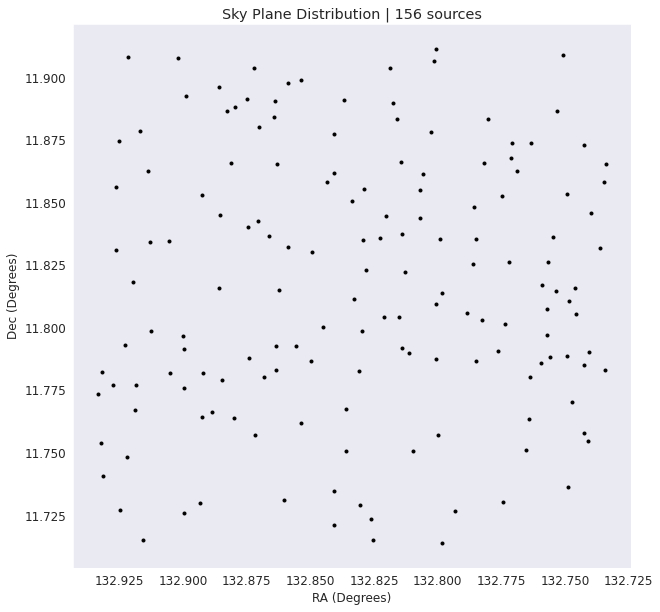

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df['RA'],df['Dec'],marker='.',color='black')
ax.set_title(f'Sky Plane Distribution | {len(df)} sources')
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')
ax.invert_xaxis()

In [10]:
if df['RA'].max()+df['RA'].min() < 360:
  cen_ra = (df['RA'].max()+df['RA'].min())/2
else :
  cen_ra = (df['RA'].max()+df['RA'].min()-360)/2

cen_dec = (df['Dec'].max()+df['Dec'].min())/2

## **Creating WCS object**

In [11]:
n_pix_main = 8000
n_pix_sub = 200
pixel_scale = 0.1 #arcsecond

w = wcs.WCS(naxis=2)
w.wcs.crpix = [n_pix_main//2,n_pix_main//2]
w.wcs.cdelt = np.array([-pixel_scale/3600, pixel_scale/3600])
w.wcs.crval = [cen_ra, cen_dec]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

## **RA Dec cut based of FoV**

In [12]:
field_ra_min  = cen_ra  - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_ra_max  = cen_ra  + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600
field_dec_min = cen_dec - 0.5*n_pix_main*pixel_scale/3600 + 0.5*n_pix_sub*pixel_scale/3600
field_dec_max = cen_dec + 0.5*n_pix_main*pixel_scale/3600 - 0.5*n_pix_sub*pixel_scale/3600

df_field = df[(df['RA']>field_ra_min) &(df['RA']<field_ra_max) &(df['Dec']>field_dec_min) &(df['Dec']<field_dec_max)]

Text(0, 0.5, 'Dec (Degrees)')

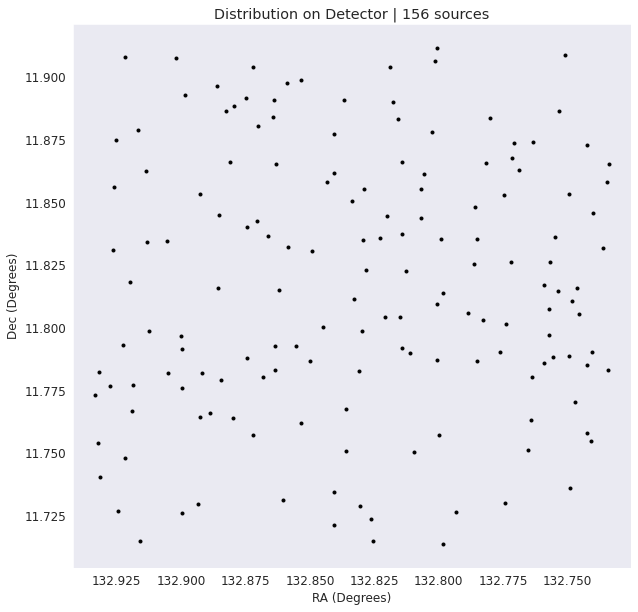

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(df_field['RA'],df_field['Dec'],marker='.',color='black')
ax.set_title(f"Distribution on Detector | {len(df)} sources")
ax.set_xlim(field_ra_min,field_ra_max )
ax.set_ylim(field_dec_min ,field_dec_max )
ax.invert_xaxis()
ax.set_xlabel('RA (Degrees)')
ax.set_ylabel('Dec (Degrees)')

## **Adding PSF at coordinates normalized by ABmag**



In [42]:
image_g_main= np.zeros((n_pix_main,n_pix_main))
f=[]
for i, row in df_field.iterrows():

  c= SkyCoord(row['RA'],row['Dec'],unit=u.deg)
  pix = w.world_to_array_index(c)

  fwhm_in = 1.8 # arcseconds

  ABmag = row['mag_nuv']

  flux = 3631*10**(-ABmag/2.5)
  f.append(flux)

  # Input FWHM based on pixel scale
  fwhm = fwhm_in/pixel_scale    

  sigma_psf = fwhm*gaussian_fwhm_to_sigma

  amplitude = flux/(sigma_psf**2*2*np.pi)

  # Creating 2D Gaussian
  model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
  y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

  # Patch with generated Gaussian
  image_g_sub = model_gauss(x,y)

  # Adding the patch to the image
  image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub

In [43]:
np.array(f).sum(),image_g_main.sum()  # Checking if flux is conserved

(0.11916120851775977, 0.11916120851775978)

Can simulate 2D gaussians of 21702 sources in 50s

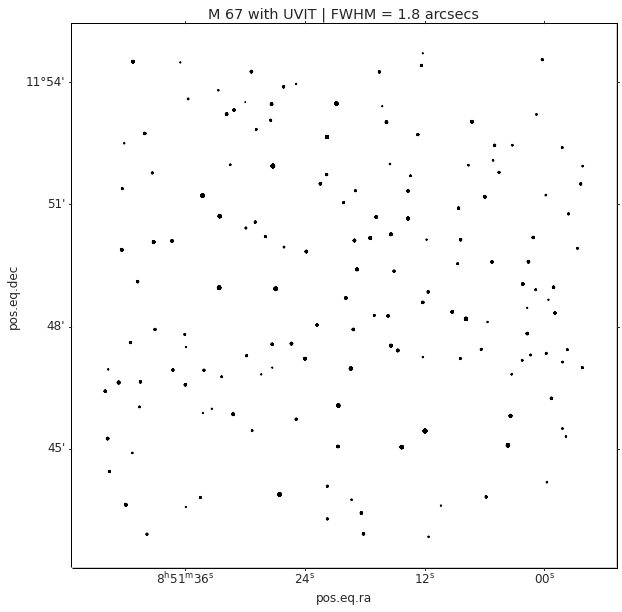

In [44]:
norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=w)
ax.patch.set_edgecolor('black')  

ax.patch.set_linewidth('3')  
img = ax.imshow(image_g_main,cmap='Greys',vmin = 1e-11,vmax = 5.5e-9 )
ax.set_title(f'M 67 with UVIT | FWHM = {fwhm_in} arcsecs');


# **PSF using CasJobs**

## **Query Script**

In [48]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [ ]:
class PSF_gen():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None, pixel_scale=0.1,fwhm_in=0.3,n_pix_main=8000,n_pix_sub=200):   

        self.pixel_scale = pixel_scale
        self.fwhm = fwhm_in/pixel_scale
        self.n_pix_main = n_pix_main
        self.n_pix_sub = n_pix_sub

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"
        self.wcs = self.create_wcs()
        self.df_field = self.create_field()
        self.image = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = wcs.WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      return w

    def create_field(self):
      """
      Function for selecting sources within a box field. The box field size depends on n_pix_main, pixel_scale and n_pix_sub
     """
      field_ra_min  = self.ra  - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_ra_max  = self.ra  + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_min = self.dec - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_max = self.dec + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600

      df_field = self.df[(self.df['ra']>field_ra_min) &(self.df['ra']<field_ra_max) &(self.df['dec']>field_dec_min) &(self.df['dec']<field_dec_max)]
      return df_field
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df_field['ra'],self.df_field['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*self.n_pix_main/3600,3)} degrees | {len(self.df_field)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.zeros((self.n_pix_main,self.n_pix_main))
      f=[]
      for i, row in self.df_field.iterrows():
          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)

          ABmag = row['mag_nuv']
          flux = 3631*10**(-ABmag/2.5)
          f.append(flux)     
          sigma_psf = self.fwhm*gaussian_fwhm_to_sigma

          amplitude = flux/(sigma_psf**2*2*np.pi)
          model_gauss = models.Gaussian2D(amplitude,n_pix_sub//2 , n_pix_sub//2 , sigma_psf, sigma_psf)
          y, x  = np.mgrid[0:(n_pix_sub), 0:(n_pix_sub)]

          image_g_sub = model_gauss(x,y)

          image_g_main[pix[0]-n_pix_sub//2:pix[0]+n_pix_sub//2,pix[1]-n_pix_sub//2:pix[1]+n_pix_sub//2]+=image_g_sub
      if np.round(np.array(f).sum(),4)!= np.round(image_g_main.sum(),4):
          print("Patch width is too small")
      self.image = image_g_main
        
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)
          norm = ImageNormalize(stretch=LogStretch())

          ax.imshow(image,cmap='gray',vmin = 1e-11,vmax = 5.5e-9 )  #
          ax.set_title(f'Requested center : {self.name}\n Pixel Scale : {self.pixel_scale} | FWHM = {self.fwhm*self.pixel_scale} arcsecs')
          ax.invert_xaxis()
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image)
          hdu.wcs= self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}.fits')
      else:
          print("Generate PSF")


## **Query**

In [ ]:
#df = pd.read_csv('M67.csv')

In [ ]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"
pixel_scale = float(input("Pixel scale (arcseconds/pixel) : ") or "0.1")
fwhm_in = float(input("FWHM in arcseconds : " )or "0.3")

Source name (Eg. M 67, 06h 03m 20s 42 18 00) : 
Pixel scale (arcseconds/pixel) : 
FWHM in arcseconds : 


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f092cce7510>)

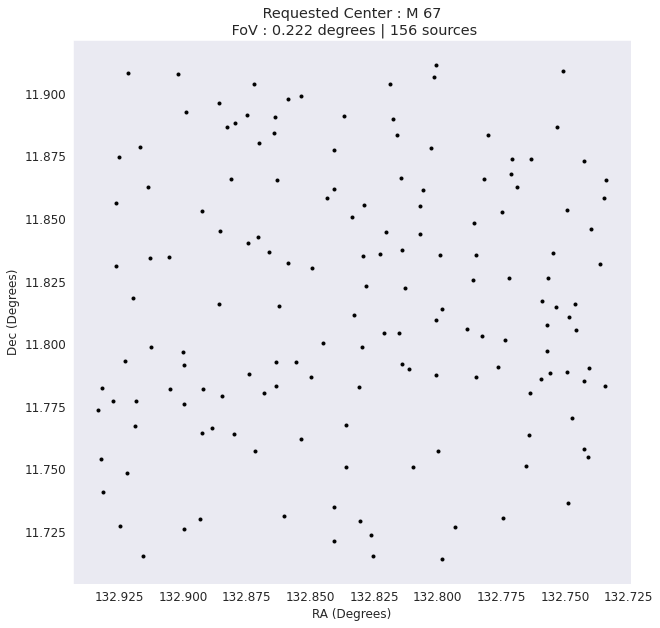

In [ ]:
psf = PSF_gen(name, pixel_scale = pixel_scale, fwhm_in =fwhm_in)
psf.generate_psf()
psf.show_field()

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7f0921cf4710>)

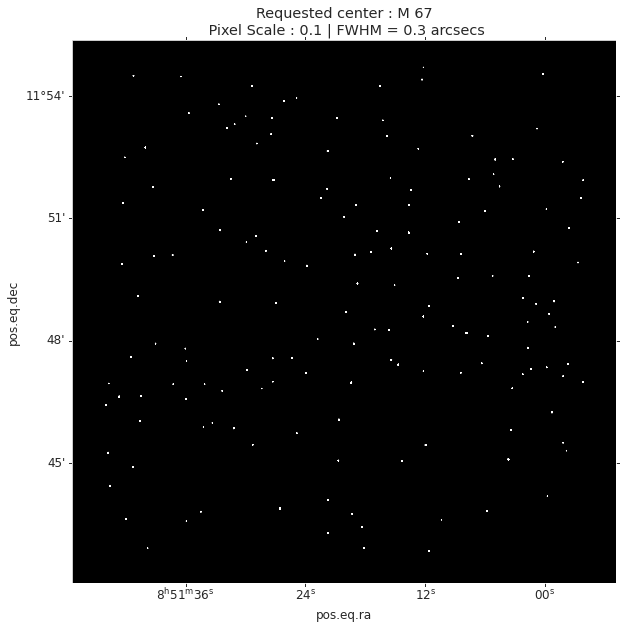

In [ ]:
psf.show_image()

# **HCIPy**

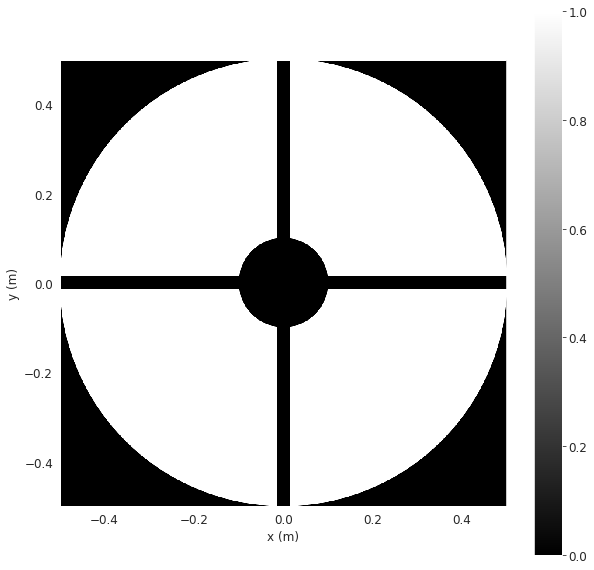

In [61]:
pupil_diameter = 1.0 # m

effective_focal_length = 20 # m
wavelength = 150e-9 # m

pupil_grid = make_pupil_grid(1024, diameter = pupil_diameter)

aperture = make_obstructed_circular_aperture(1,0.2,num_spiders=4,spider_width= 0.03)

telescope_pupil = evaluate_supersampled(aperture , pupil_grid  ,8)

im = imshow_field(telescope_pupil, cmap='gray')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [81]:
flux = 1

In [85]:
focal_total = 0

for wavelength in np.linspace(150,300,10)*1e-9:

  amplitude = flux*wavelength
  wavefront = Wavefront(amplitude*telescope_pupil,wavelength)
  focal_grid = make_focal_grid(q=3, num_airy=50,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
  prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
  focal_image = prop.forward(wavefront)
  focal_total += focal_image.amplitude.shaped

In [86]:
focal_image.amplitude.shaped.shape

(180, 180)

In [87]:
np.array(focal_total/10).sum()

3.837696247366874e-06

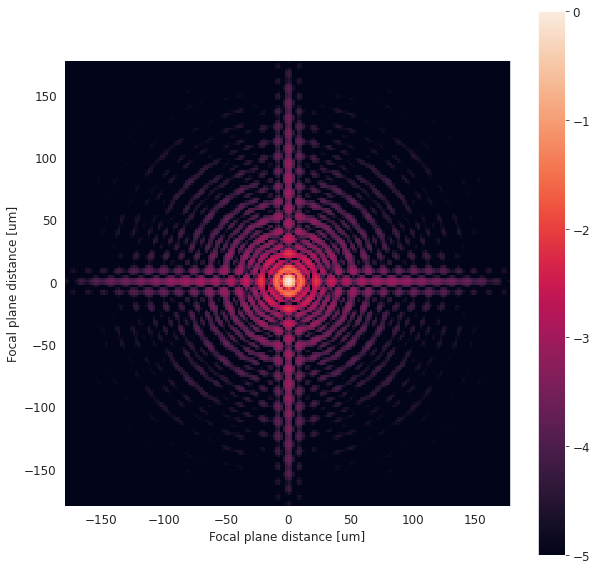

In [88]:
img = imshow_field(np.log10(focal_image.intensity/focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
plt.xlabel('Focal plane distance [um]')
plt.ylabel('Focal plane distance [um]')
plt.colorbar()
plt.show()

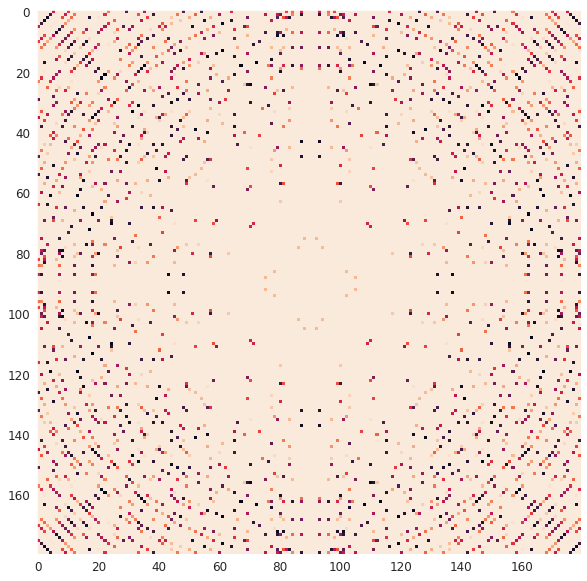

In [73]:
plt.imshow(focal_image.amplitude.shaped,vmin=1e-9,vmax=1e-5)

In [56]:
class PSF_gen_v2():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None, cols = None,n_pix_main=8000):   

        self.pixel_scale = 0.1
        self.n_pix_sub   = 2500
        self.n_pix_main  = n_pix_main + self.n_pix_sub

        if name is not None and df is None:
          self.name        = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
          self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                              FROM
                              gcat_asc
                              WHERE
                              ra BETWEEN {self.ra} -0.1 AND {self.ra}+0.1
                              AND 
                              dec BETWEEN {self.dec}-0.1 AND {self.dec}+0.1
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else: 
          if cols is not None:
            self.df = df.rename(columns = cols) 
          else :
            self.df =  df
          self.ra   = (self.df['ra'].max()+self.df['ra'].min())/2
          self.dec  = (self.df['dec'].max()+self.df['dec'].min())/2
          self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"
        self.wcs = self.create_wcs()
        self.df_field = self.create_field()
        self.image = None
        
    def create_wcs(self):
      """
      Function for creating WCS object for given ra and dec of a field or a catalog using pixel scale and n_pix_main
      """
      w = wcs.WCS(naxis=2)
      w.wcs.crpix = [self.n_pix_main//2,self.n_pix_main//2]
      w.wcs.cdelt = np.array([self.pixel_scale/3600, self.pixel_scale/3600])
      w.wcs.crval = [self.ra, self.dec]
      w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
      return w

    def create_field(self):
      """
      Function for selecting sources within a box field. The box field size depends on n_pix_main, pixel_scale and n_pix_sub
     """
      field_ra_min  = self.ra  - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_ra_max  = self.ra  + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_min = self.dec - 0.5*self.n_pix_main*self.pixel_scale/3600 + 0.5*self.n_pix_sub*self.pixel_scale/3600
      field_dec_max = self.dec + 0.5*self.n_pix_main*self.pixel_scale/3600 - 0.5*self.n_pix_sub*self.pixel_scale/3600

      df_field = self.df[(self.df['ra']>field_ra_min) &(self.df['ra']<field_ra_max) &(self.df['dec']>field_dec_min) &(self.df['dec']<field_dec_max)]
      return df_field
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df_field['ra'],self.df_field['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*self.n_pix_main/3600,3)} degrees | {len(self.df_field)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
    def generate_psf(self):
      """
      This function creates PSFs based on ABmag and FWHM which  on a small patch (2D array) of size n_pix_sub*n_pix_sub. 
      The patch with the PSF is then added to the image array of size n_pix_main*n_pix_sub using wcs object.
      """
      n_pix_sub = self.n_pix_sub
      image_g_main = np.zeros((self.n_pix_main,self.n_pix_main))
      #image_g_main = np.random.rand(self.n_pix_main,self.n_pix_main)*1e-8

      # Simulating Spider obstruction
      pupil_diameter         = 1.0 # m
      effective_focal_length = 20 # m
      wavelength             = 150e-9 # m
      pupil_grid             = make_pupil_grid(1024, diameter = pupil_diameter)
      aperture               = make_obstructed_circular_aperture(1,0.2,num_spiders=4,spider_width=0.03)
      telescope_pupil        = evaluate_supersampled(aperture , pupil_grid  ,8)  

      for i, row in self.df_field.iterrows():
          c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
          pix = self.wcs.world_to_array_index(c)

          ABmag = row['mag_nuv']
          if ABmag>20:
            box_width = 50
            const = 6.912065286401603

          elif ABmag>15 and ABmag<=20:
            box_width = 200
            const = 13.700002631862889
          else:
            box_width = 500
            const = 19.945915735159097

          flux = 3631*10**(-ABmag/2.5)
          focal_total = 0 

          for wavelength in np.linspace(150,300,10)*1e-9:
            
            amplitude = flux*wavelength/const
            wavefront = Wavefront(amplitude*telescope_pupil,wavelength)

            focal_grid = make_focal_grid(q=3, num_airy = box_width ,pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
            prop = FraunhoferPropagator( pupil_grid, focal_grid, focal_length=effective_focal_length)
            focal_image = prop.forward(wavefront)
            focal_total += focal_image.amplitude.shaped

          image_g_sub = np.array(focal_total)/10

          if np.round(flux,4)!= np.round(image_g_sub.sum(),4):
              print(f"Patch width is too small for {ABmag,flux,image_g_sub.sum()}")

          array_width = 3*box_width

          image_g_main[pix[0]-array_width:pix[0]+array_width,pix[1]-array_width:pix[1]+array_width]+=image_g_sub

          
      self.image = image_g_main[self.n_pix_main//2-4000:self.n_pix_main//2+4000,self.n_pix_main//2-4000:self.n_pix_main//2+4000]-1e-8
      return f
        
    def show_image(self):
      """
      Function for plotting the simulated field with PSFs
      
      Returns
      -------
      fig, ax
      """
      if np.all(self.image) !=None:
          fig = plt.figure(figsize = (15,10))
          ax = fig.add_subplot(projection=self.wcs)
          image = self.image.astype(np.float32)

          ax.imshow(image,cmap='Greys',vmin=1e-12,vmax=3e-8 )  #
          ax.set_title(f'Requested center : {self.name}')
          ax.invert_xaxis()
          return fig,ax
      else:
          print("Generate PSF")
    def writeto(self,name):
      """
      Function for downloading a fits file of simulated field
      """
      if np.all(self.image) !=None:
          hdu = fits.PrimaryHDU(self.image)
          hdu.wcs= self.wcs
          hdul = fits.HDUList([hdu])
          hdul.writeto(f'{name}.fits')
      else:
          print("Generate PSF")


In [58]:
name = input("Source name (Eg. M 67, 06h 03m 20s 42 18 00) : ") or "M 67"

Source name (Eg. M 67, 06h 03m 20s 42 18 00) : 


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbbf1432690>)

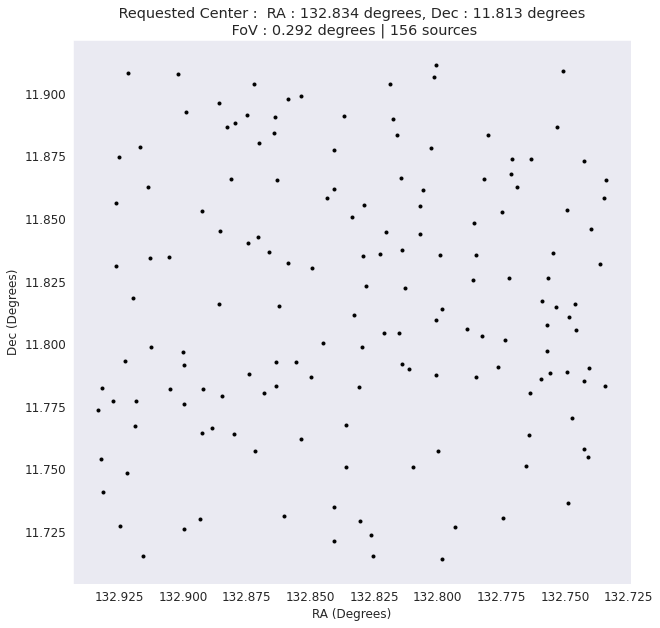

In [89]:
df = pd.read_csv('M67.csv')
psf = PSF_gen_v2(df=df)
f   = psf.generate_psf()
psf.show_field()

10m 55s

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7fbbf575fc50>)

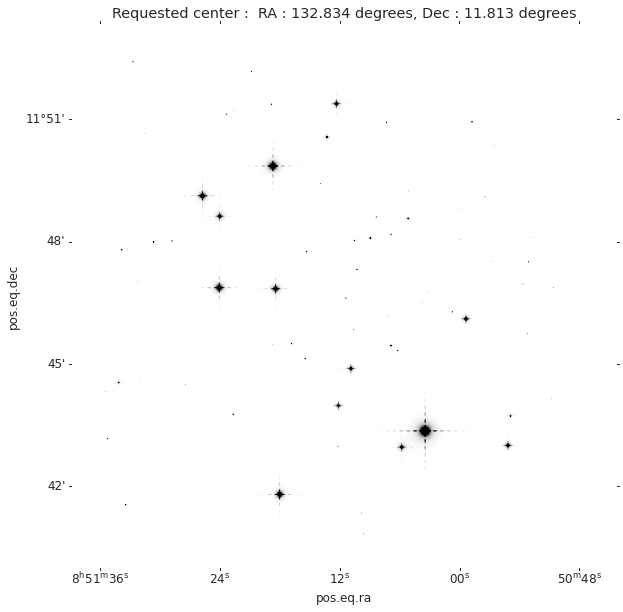

In [90]:
psf.show_image()

In [54]:
image = psf.image

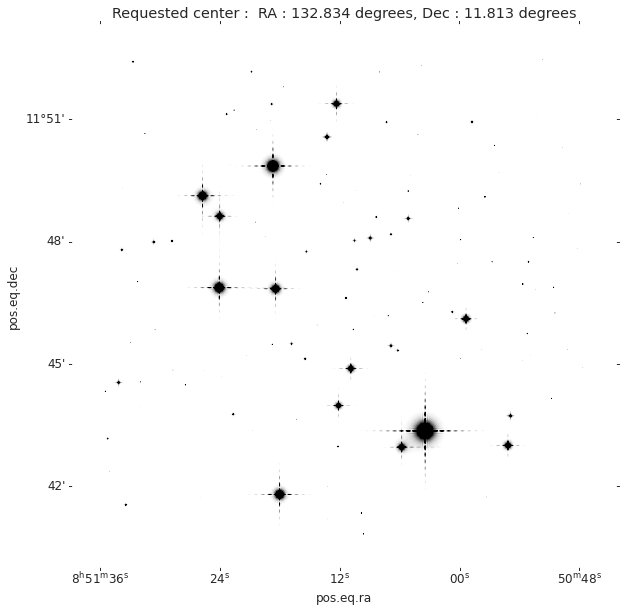

In [93]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(projection=psf.wcs)
ax.imshow(image,cmap='Greys',vmin=1e-12,vmax=3e-8 )  #
ax.set_title(f'Requested center : {psf.name}')
ax.invert_xaxis()